# Graph Isomorphism and Jumping Knowledge

Xu et al. (2018) posit that a GNN with maximal discriminative power could distinguish between distinct graph structures by mapping them onto unique representations in the embedding space. To achieve this, they proposed the Graph Isomorphism Network (GIN), a neural network architecture that extends the Weisfeiler-Lehman test. By doing so, they could ensure that isomorphic graphs were mapped onto identical representations while non-isomorphic graphs were mapped onto distinct ones. Furthermore, they have demonstrated that the GIN achieves the greatest discriminative power among all GNNs. Subsequently, Hu et al. (2019) augmented the GIN model with a pre-training strategy to mitigate negative transfer effects in downstream tasks, leading to promising results on benchmark datasets.

Given a pair of graphs $\mathcal{G}_1$ and $\mathcal{G}_2$, Hamilton (2023) summerized the goal of graph isomorphism testing is to declare whether or not these two graphs are isomorphic, formally, if or not the following conditions hold

$$
\textbf{P}\textbf{A}_1\textbf{P}^{\top} = \textbf{A}_2 \text{ and } \textbf{P}\textbf{X}_1 = \textbf{X}_2
$$

where $\textbf{P}$ is a permutation matrix, $\textbf{A}_1$ and $\textbf{A}_2$ are adjacency matrices of $\mathcal{G}_1$ and $\mathcal{G}_2$, as well as node features $\textbf{X}_1$ and $\textbf{X}_2$.

Jumping Knowledge (JK) (Xu et al., 2018) is a network architecture that can be combined with GIN, providing an adaptive means to adjust the influence radii of each node and task through the selective combination of various aggregations at the final layer. In other words, it breaks the assumption of utilizing the output of the final layer of the GNN. Thus, it could facilitate improved structure-aware representations. In this approch, Hamilton (2023) defined the final node representations $\textbf{z}_u$ as

$$
\textbf{z}_u = f_{\text{JK}} \left( \textbf{h}_u^{(0)} \oplus \textbf{h}_u^{(1)} \oplus \cdots \oplus \textbf{h}_u^{(K)} \right)
$$

where $f_{\text{JK}}$ is an arbitrary differentiable function.

In our study, we employed DGL-LifeSci and RdKit to integrate the pre-training strategies of GIN and JK. To perform featurization of chemical compounds, we one-hot encoded atoms and their corresponding chiralities into graphs, which also accounted for four types of chemical bonds (single, double, triple, and aromatic) and three directions of bonds (end upright, end downright, and none).

In [1]:
import sys

sys.path.insert(0, '..')

In [9]:
from data.dataset import Dataset
import torch
from sklearn.metrics import mean_squared_error, r2_score
from model.dgl.DGLModel import DGLModel
from data.featurization.dgl_Graph import DGL_Graph
from model.abstractmodel import AbstractModel
from ray import tune
import pandas as pd
import numpy as np

In [3]:
TRN = Dataset.load_csv("ds/TRN_DC")
TST1 = Dataset.load_csv("ds/TST_1")
TST2 = Dataset.load_csv("ds/TST_2")

In [4]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="Pretrain",
    self_loop=True
)
TRN.X = TRN.featurize(featurizer)
TST1.X = TST1.featurize(featurizer)
TST2.X = TST2.featurize(featurizer)

In [5]:
trn_sets, val_sets = TRN.k_fold_split(5)

In [5]:
RANDOM_STATE = 1234
SPACE = {
    "pretrained": tune.choice(["gin_supervised_contextpred", "gin_supervised_infomax",
                               "gin_supervised_edgepred", "gin_supervised_masking"]),
    "num_layers": tune.choice([2, 3, 5, 7]),
    "emb_dim": tune.choice([200, 250, 300, 350, 400]),
    "JK": tune.choice(["concat", "last", "max", "sum"]),
    "readout": tune.choice(["sum", "mean", "max", "attention"]),
    "dropout": tune.uniform(0, 1),
    "weight_decay": tune.uniform(0, 1),
    "epoch": tune.choice([100, 200, 300])
}

In [6]:
from model.dgl.GIN import GIN
import numpy as np


def trainable_func(config: dict, dataset: Dataset):
    AbstractModel.set_seed(RANDOM_STATE)
    trn, val = dataset.split()
    model = GIN(
        task_type="regression",
        # GIN Configuration
        pretrained=config["pretrained"],
        n_tasks=1,
        num_node_emb_list=[
            len(featurizer.node_featurizer._atomic_number_types) + 1,
            len(featurizer.node_featurizer._chiral_types) + 1
        ],
        num_edge_emb_list=[
            len(featurizer.edge_featurizer._bond_types) + 1,
            len(featurizer.edge_featurizer._bond_direction_types) + 1
        ],
        num_layers=config["num_layers"],
        emb_dim=config["emb_dim"],
        JK=config["JK"],
        dropout=config["dropout"],
        readout=config["readout"],
        # Abstract DGL Configuration
        lr=0.01,
        y_name="LogS exp (mol/L)",
        weight_decay=config["weight_decay"],
        batch_size=1024,
        verbose=False
    )
    scores = model.fit(trn, val=val, epochs=config["epoch"], verbose=False)
    tune.report(rmse=np.average(scores["rmse"]))

In [7]:
from ray.tune.search import BasicVariantGenerator

tuner = DGLModel.tuner(
    trainable_func,
    SPACE,
    num_samples=50,
    search_alg=BasicVariantGenerator(max_concurrent=1),
    dataset=TRN
)
tune_result = tuner.fit()

2023-03-18 13:58:02,924	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,node_ip,pid,rmse,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
trainable_func_e32fa_00000,2023-03-18_14-01-20,False,,9e04caaff18f448198d21e5c3b87dd32,64-4090-13700K,1,127.0.0.1,16036,3.09658,189.804,189.804,189.804,1679148080,0,,1,e32fa_00000,0.00400186


2023-03-18 15:55:22,746	INFO tune.py:798 -- Total run time: 7035.48 seconds (7035.37 seconds for the tuning loop).


In [8]:
best_result = tune_result.get_best_result(metric="rmse", mode="min")
best_result.config

{'pretrained': 'gin_supervised_contextpred',
 'num_layers': 5,
 'emb_dim': 300,
 'JK': 'sum',
 'readout': 'mean',
 'dropout': 0.9901561711914358,
 'weight_decay': 0.13639557029318083,
 'epoch': 300}

In [8]:
from model.dgl.GIN import GIN

MODEL = GIN(
    task_type="regression",
    # GIN Configuration
    pretrained='gin_supervised_contextpred',
    n_tasks=1,
    num_node_emb_list=[
        len(featurizer.node_featurizer._atomic_number_types) + 1,
        len(featurizer.node_featurizer._chiral_types) + 1
    ],
    num_edge_emb_list=[
        len(featurizer.edge_featurizer._bond_types) + 1,
        len(featurizer.edge_featurizer._bond_direction_types) + 1
    ],
    num_layers=2,
    emb_dim=300,
    JK="last",
    dropout=0.3,
    readout='mean',
    # Abstract DGL Configuration
    lr=0.001,
    y_name="LogS exp (mol/L)",
    weight_decay=0.13639557029318083,
    batch_size=1024
)
trn, val = TRN.split()
scores = MODEL.fit(trn, val=val, epochs=150)

[INFO] Expect to use 'DGL_Graph_Pretrain' to featurize SMILES
[INFO] Device cuda


100%|██████████| 150/150 [01:17<00:00,  1.93it/s, loss: 6.545 rmse: 1.682]


<AxesSubplot: >

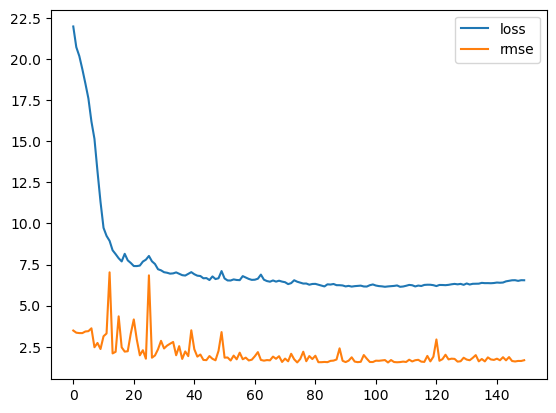

In [9]:
pd.DataFrame({
    "loss": [v.item() for v in MODEL.scores["loss"]],
    "rmse": [v.item() for v in MODEL.scores["rmse"]]
}).plot()

In [11]:
result = MODEL.cross_validate(
    dataset=TRN,
    epochs=130,
    extra_eval_set=TST1,
    cv=4,
    verbose=True
)

[CV 3]: 100%|██████████| 130/130 [01:02<00:00,  2.07it/s, loss: 8.566, val_rmse: 1.512] 


In [14]:
np.std(result["rmse"]), np.mean(result["rmse"])

(1.2647163, 2.6416335)

In [15]:
print(f"TST1 : RMSE {mean_squared_error(TST1.y, MODEL.predict(TST1).cpu(), squared=False)}")
print(f"TST2 : RMSE {mean_squared_error(TST2.y, MODEL.predict(TST2).cpu(), squared=False)}")

TST1 : RMSE 1.8257275574307552
TST2 : RMSE 2.840509037364699


In [6]:
SPACE = {
    "num_layers": tune.uniform(2, 8),
    "emb_dim": tune.uniform(200, 400),
    "dropout": tune.uniform(0, 1),
    "weight_decay": tune.uniform(0, 1)
}

In [7]:
from model.dgl.GIN import GIN


def trainable_func(config: dict, dataset: Dataset):
    trn, val = dataset.split()
    model = GIN(
        task_type="regression",
        # GIN Configuration
        pretrained='gin_supervised_contextpred',
        n_tasks=1,
        num_node_emb_list=[
            len(featurizer.node_featurizer._atomic_number_types) + 1,
            len(featurizer.node_featurizer._chiral_types) + 1
        ],
        num_edge_emb_list=[
            len(featurizer.edge_featurizer._bond_types) + 1,
            len(featurizer.edge_featurizer._bond_direction_types) + 1
        ],
        num_layers=int(config["num_layers"]),
        emb_dim=int(config["emb_dim"]),
        JK="last",
        dropout=config["dropout"],
        readout="mean",
        # Abstract DGL Configuration
        lr=0.01,
        y_name="LogS exp (mol/L)",
        weight_decay=config["weight_decay"],
        batch_size=1024,
        verbose=False
    )
    scores = model.fit(trn, val=val, epochs=130, verbose=False)
    tune.report(rmse=np.average(scores["rmse"]))

In [8]:
from ray.tune.search.bayesopt import BayesOptSearch
from ray.tune.search import ConcurrencyLimiter

tuner = DGLModel.tuner(
    trainable_func,
    space=SPACE,
    num_samples=30,
    search_alg=ConcurrencyLimiter(BayesOptSearch(metric="rmse", mode="min"), max_concurrent=1),
    dataset=TRN
)
tune_result = tuner.fit()

2023-03-18 18:34:04,746	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,node_ip,pid,rmse,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
trainable_func_3d0ee491,2023-03-18_18-35-28,False,,b00a3460bf644d96a9dd6d93102c9bf5,64-4090-13700K,1,127.0.0.1,11504,3.16511,76.7634,76.7634,76.7634,1679164528,0,,1,3d0ee491,0.00499964


2023-03-18 19:06:14,466	INFO tune.py:798 -- Total run time: 1925.70 seconds (1925.60 seconds for the tuning loop).


In [9]:
best_result = tune_result.get_best_result(metric="rmse", mode="min")
best_result.config

{'num_layers': 5.7374257490399065,
 'emb_dim': 208.6305220695066,
 'dropout': 0.5471241966662174,
 'weight_decay': 0.0}

In [20]:
from model.dgl.GIN import GIN

num_heads = 5
AbstractModel.set_seed(2387)

k_pred_tst1 = []
k_pred_tst2 = []

for trn, val in zip(trn_sets, val_sets):
    model = GIN(
        task_type="regression",
        # GIN Configuration
        pretrained='gin_supervised_contextpred',
        n_tasks=1,
        num_node_emb_list=[
            len(featurizer.node_featurizer._atomic_number_types) + 1,
            len(featurizer.node_featurizer._chiral_types) + 1
        ],
        num_edge_emb_list=[
            len(featurizer.edge_featurizer._bond_types) + 1,
            len(featurizer.edge_featurizer._bond_direction_types) + 1
        ],
        num_layers=5,
        emb_dim=208,
        JK="last",
        dropout=0.5471241966662174,
        readout="mean",
        # Abstract DGL Configuration
        lr=0.001,
        y_name="LogS exp (mol/L)",
        weight_decay=0,
        batch_size=1024
    )
    model.fit(trn, val=val, epochs=400, min_epoch=80, early_stop=20)

    k_pred_tst1.append(model.predict(TST1).cpu())
    k_pred_tst2.append(model.predict(TST2).cpu())

[INFO] Expect to use 'DGL_Graph_Pretrain' to featurize SMILES
[INFO] Device cuda


 25%|██▌       | 101/400 [00:54<02:41,  1.85it/s, loss: 6.206 rmse: 3.381]


[INFO] Expect to use 'DGL_Graph_Pretrain' to featurize SMILES
[INFO] Device cuda


 48%|████▊     | 191/400 [02:02<02:14,  1.56it/s, loss: 4.554 rmse: 1.783]


[INFO] Expect to use 'DGL_Graph_Pretrain' to featurize SMILES
[INFO] Device cuda


 36%|███▌      | 143/400 [01:25<02:33,  1.67it/s, loss: 5.132 rmse: 1.862]


[INFO] Expect to use 'DGL_Graph_Pretrain' to featurize SMILES
[INFO] Device cuda


 30%|███       | 120/400 [01:18<03:03,  1.53it/s, loss: 6.772 rmse: 1.270]


[INFO] Expect to use 'DGL_Graph_Pretrain' to featurize SMILES
[INFO] Device cuda


 34%|███▍      | 138/400 [01:30<02:52,  1.52it/s, loss: 5.583 rmse: 1.148]


In [21]:
pred_tst1 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst1, 1)]
pred_tst2 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst2, 1)]

In [22]:
print(f"TST1 : RMSE {mean_squared_error(TST1.y, pred_tst1, squared=False)}")
print(f"TST2 : RMSE {mean_squared_error(TST2.y, pred_tst2, squared=False)}")

TST1 : RMSE 1.2819307093497843
TST2 : RMSE 2.1152205627992084


In [23]:
print(f"TST1 : R^2 {r2_score(TST1.y, pred_tst1)}")
print(f"TST2 : R^2 {r2_score(TST2.y, pred_tst2)}")

TST1 : R^2 -0.02551947797347376
TST2 : R^2 0.024592079537716693


Text(0.5, 1.0, '2019 Solubility Challenge Test Set 2 (GIN)\nRMSE: 2.115, $R^2$: 0.025')

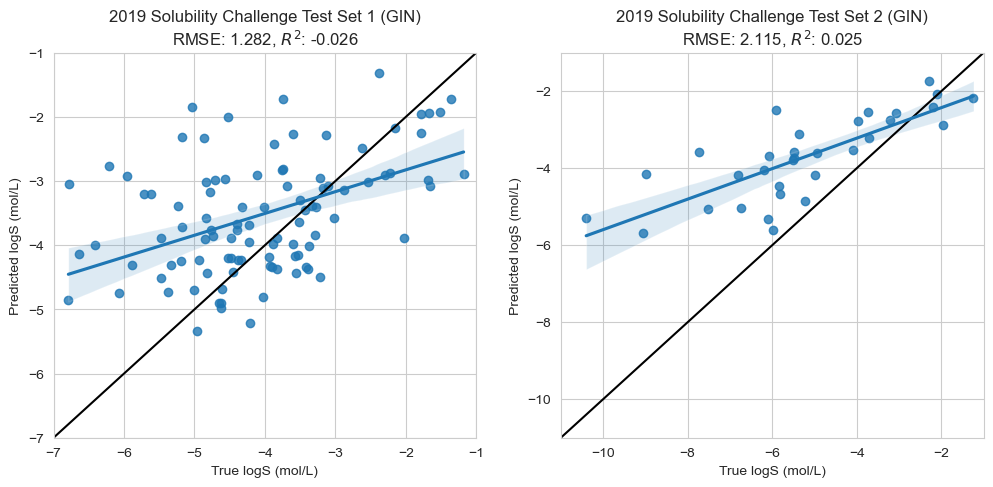

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

model_name = "GIN"
min_ax1, max_ax1 = -7, -1
min_ax2, max_ax2 = -11, -1

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.lineplot(x=[min_ax1, max_ax1], y=[min_ax1, max_ax1], ax=ax1, color="black")
sns.lineplot(x=[min_ax2, max_ax2], y=[min_ax2, max_ax2], ax=ax2, color="black")

sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST1.y.values[:, 0],
        "Predicted logS (mol/L)": pred_tst1
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax1
)
sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST2.y.values[:, 0],
        "Predicted logS (mol/L)": pred_tst2
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax2
)

ax1.set_xlim(min_ax1, max_ax1)
ax1.set_ylim(min_ax1, max_ax1)
ax2.set_xlim(min_ax2, max_ax2)
ax2.set_ylim(min_ax2, max_ax2)

ax1.set_title(f"2019 Solubility Challenge Test Set 1 ({model_name})\n"
              f"RMSE: {mean_squared_error(TST1.y, pred_tst1, squared=False):.3f}, $R^2$: {r2_score(TST1.y, pred_tst1):.3f}")
ax2.set_title(f"2019 Solubility Challenge Test Set 2 ({model_name})\n"
              f"RMSE: {mean_squared_error(TST2.y, pred_tst2, squared=False):.3f}, $R^2$: {r2_score(TST2.y, pred_tst2):.3f}")

# plt.axis("equal")